In [1]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from skimage.measure import find_contours



# SETUP

In [192]:
def circle_points(r, n):
    circles = []
    for r, n in zip(r, n):
        t = np.linspace(0, 2*np.pi, n, endpoint=False)
        x = r * np.cos(t)
        y = r * np.sin(t)
        circles.append(np.c_[x, y])
    return circles

n = 60

pts = circle_points([1], [n])[0]




xx = np.linspace(0,100, 100)

positions = np.array([[xx.max()*.45,xx.max()*.45], [xx.max()*.60,xx.max()*.60]])

radii = np.array([ xx.max()*0.20, xx.max()*0.135])

PROBERAD = xx.max()*.125


#add points:
##calculate the radius associated with each point.
all_radii = np.repeat(radii, n)


##surface points:
#repeat the points and multiply by radii
t = np.tile(pts,(len(positions),1)) *np.repeat(radii, n)[:,None]
#now transform by positions
p = t+np.repeat(positions, n,axis=0)

#repeat the points and multiply by radii
et = np.tile(pts,(len(positions),1)) *np.repeat(radii+PROBERAD, n)[:,None]
#now transform by positions
ep = et+np.repeat(positions, n,axis=0)




In [193]:
#first remove any blue point that is inside another atom (and also their attendant orange points.)

dmat = cdist(p, positions)
inside = dmat.min(1)<(all_radii-0.000001)

#

p = p[~inside]
ep = ep[~inside]

all_radii = all_radii[~inside]


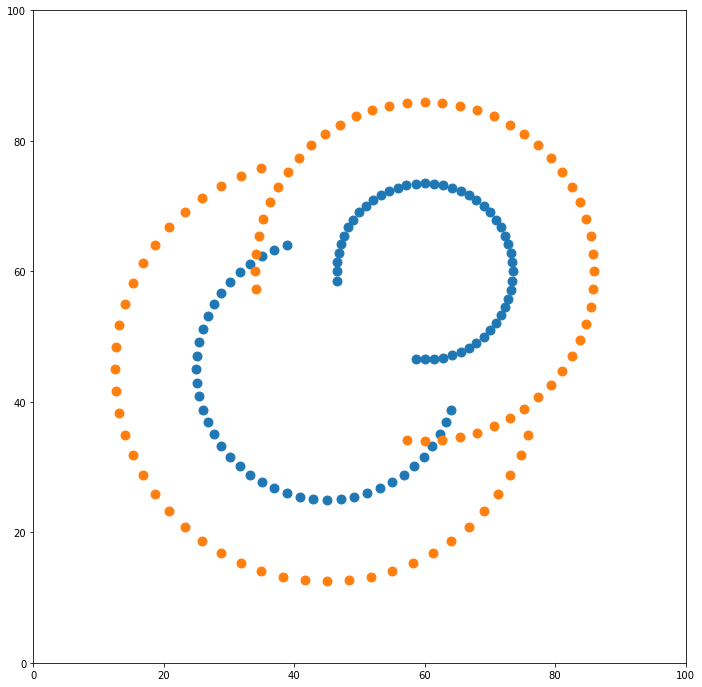

In [194]:
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(12)
ax.scatter(*p.T, s=80)
ax.scatter(*ep.T, s=80)



ax.set_xlim(0,len(xx))
ax.set_ylim(0,len(xx))
ax.set_aspect('equal')

In [195]:
#now remove any orange point that is too close to a blue point. 

dmat = cdist(ep, p)
too_close = dmat.min(1)<(PROBERAD-0.000001)

ep = ep[~too_close]
dmat = dmat[~too_close]

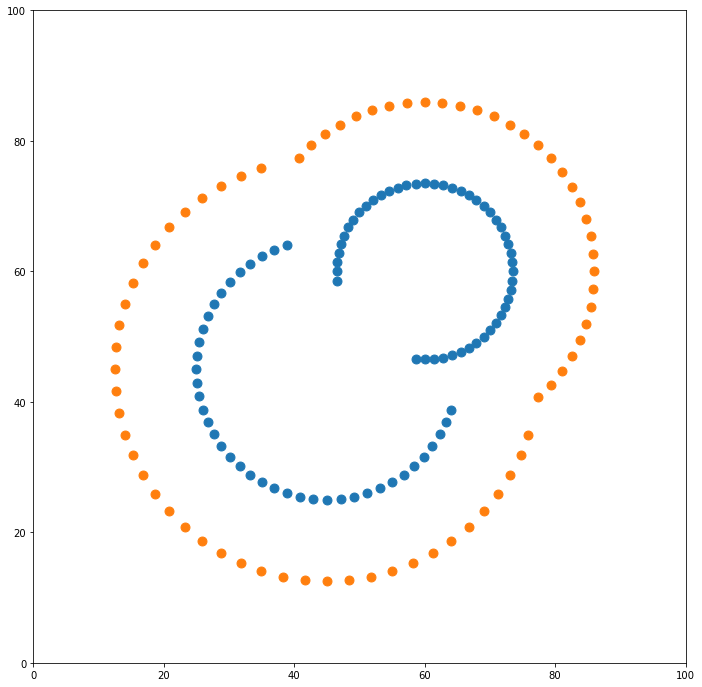

In [196]:
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(12)

ax.scatter(*p.T, s=80)
ax.scatter(*ep.T, s=80)



ax.set_xlim(0,len(xx))
ax.set_ylim(0,len(xx))
ax.set_aspect('equal')

In [198]:
blue_idx = dmat.min(0)>(PROBERAD+0.0001)
orange_idx = dmat[:,blue_idx].argmin(0)
vec = ep[orange_idx] - p[blue_idx]
scaling = 1 - (PROBERAD / np.linalg.norm(vec,axis=1))
p[blue_idx] +=(scaling[:,None]*vec)

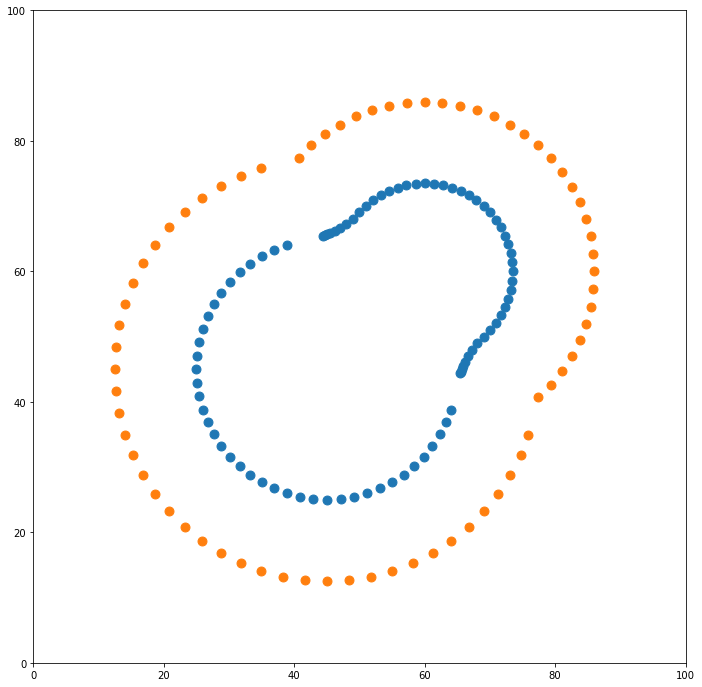

In [199]:
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(12)

ax.scatter(*p.T, s=80)
ax.scatter(*ep.T, s=80)



ax.set_xlim(0,len(xx))
ax.set_ylim(0,len(xx))
ax.set_aspect('equal')

# Interpolate onto a grid:

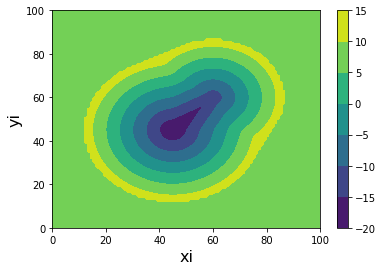

In [203]:
pts3 = np.vstack([p,ep, positions])
z3 = np.hstack([np.zeros(p.shape[0]),np.ones(ep.shape[0])*PROBERAD, -radii])



from scipy.interpolate import griddata

a,b = np.meshgrid(xx, xx)
grid = np.stack((a.ravel(), b.ravel()),axis=1)


# interpolate
zi = griddata((pts3[:,0], pts3[:,1]),z3, (a,b),method='linear', fill_value = 10)

# # mask out the field
# zi[mask] = np.nan

# plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.contourf(a,b,zi,)

plt.xlabel('xi',fontsize=16)
plt.ylabel('yi',fontsize=16)
plt.colorbar()




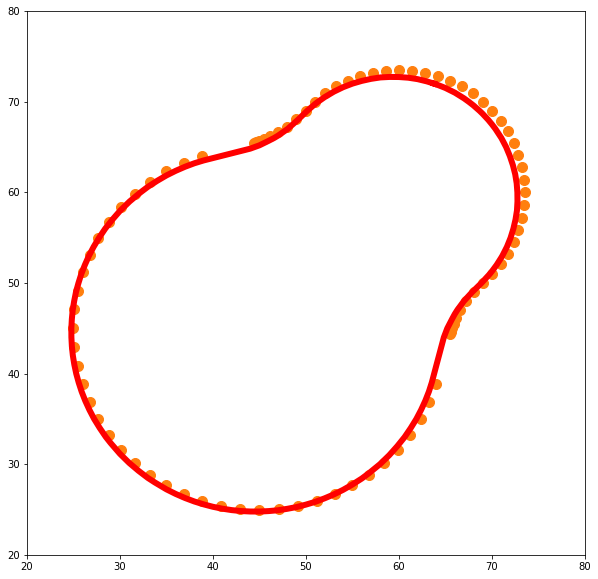

In [204]:
fig,ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)
contours = find_contours(zi, 0)
for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=6, c='red')

# ax.set_xlim(0,xx.max())
# ax.set_ylim(0,xx.max())
ax.set_xlim(20,80)
ax.set_ylim(20,80)
ax.scatter(*p.T,s=100,c='C1')


# Try a molecule!

In [215]:
def golden_spiral(num_pts, radius=1):

    indices = np.arange(0, num_pts, dtype=float) + 0.5
    phi = np.arccos(1 - 2*indices/num_pts)
    theta = np.pi * (1 + 5**0.5) * indices
    x, y, z = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi);
    points = np.vstack([x,y,z]).T
    return points*radius



n = 60

pts = golden_spiral(n)

In [237]:
from mol3d import Mol3D
from rdkit import Chem

mol = Mol3D('CC(C)N1C[C@H](C)[C@H](NC(=O)N2Cc3ccccc3[C@@H]2C)C1')
mol.embed3d(1, hydrogens=False)

positions = mol.get_pos(0)
radii = np.array([Chem.GetPeriodicTable().GetRvdw(a.GetAtomicNum()) for a in mol.mol.GetAtoms()])


In [238]:
PROBERAD = 1.4

In [239]:
#add points:

##calculate the radius associated with each point.
all_radii = np.repeat(radii, n)


##surface points:
#repeat the points and multiply by radii
t = np.tile(pts,(len(positions),1)) *np.repeat(radii, n)[:,None]
#now transform by positions
p = t+np.repeat(positions, n,axis=0)

#repeat the points and multiply by radii
et = np.tile(pts,(len(positions),1)) *np.repeat(radii+PROBERAD, n)[:,None]
#now transform by positions
ep = et+np.repeat(positions, n,axis=0)

In [240]:
#first remove any blue point that is inside another atom (and also their attendant orange points.)

dmat = cdist(p, positions)
inside = dmat.min(1)<(all_radii-0.000001)

#

p = p[~inside]
ep = ep[~inside]

all_radii = all_radii[~inside]


In [241]:
#now remove any orange point that is too close to a blue point. 

dmat = cdist(ep, p)
too_close = dmat.min(1)<(PROBERAD-0.000001)

ep = ep[~too_close]
dmat = dmat[~too_close]

In [242]:
blue_idx = dmat.min(0)>(PROBERAD+0.0001)
orange_idx = dmat[:,blue_idx].argmin(0)
vec = ep[orange_idx] - p[blue_idx]
scaling = 1 - (PROBERAD / np.linalg.norm(vec,axis=1))
p[blue_idx] +=(scaling[:,None]*vec)

In [243]:
pts3 = np.vstack([p,ep, positions])
z3 = np.hstack([np.zeros(p.shape[0]),np.ones(ep.shape[0])*PROBERAD, -radii])



In [255]:
buff = max(radii)+0.6

x1, y1, z1 = np.rint((positions.min(0)-buff)*10)/10
x2, y2, z2 = np.rint((positions.max(0)+buff)*10)/10

x = np.arange(x1, x2, 0.5)
y = np.arange(y1, y2, 0.5)
z = np.arange(z1,z2, 0.5)

a,b,c = np.meshgrid(x, y, z)
grid = np.stack((a.ravel(), b.ravel(), c.ravel()), axis=1)

In [256]:
%%time
zi = griddata((pts3[:,0], pts3[:,1], pts3[:,2]), z3, (a,b,c),method='linear', fill_value = PROBERAD)



CPU times: user 567 ms, sys: 12.4 ms, total: 580 ms
Wall time: 194 ms


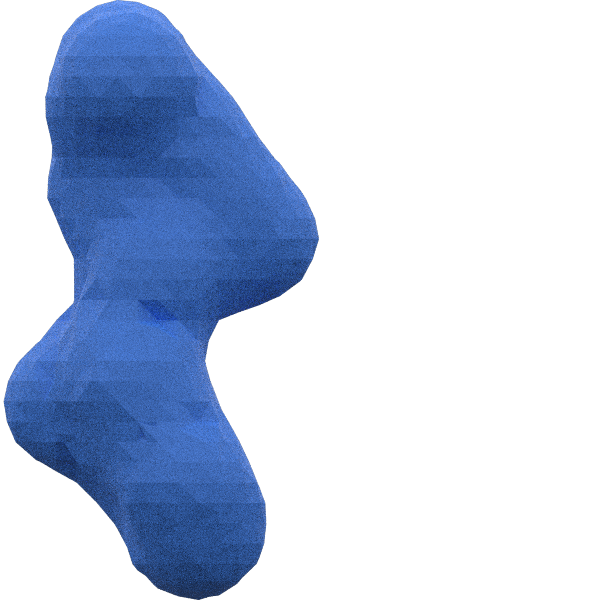

In [257]:
from skimage.measure import marching_cubes_lewiner
import fresnel

vert, faces, norm, values= marching_cubes_lewiner(zi, 0,spacing=(1,1,1))

view='front'

n_samples = 50
scene1 = fresnel.Scene()
geom = fresnel.geometry.Mesh(scene1,vertices=vert[faces].reshape(-1,3),N=1)
geom.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]), roughness=0.6)
scene1.camera = fresnel.camera.fit(scene1,view=view, margin=0)
scene1.lights = fresnel.light.cloudy()
fresnel.pathtrace(scene1, samples=n_samples, h=600, w=600)



In [258]:
import py3Dmol

p_O3A = py3Dmol.view(width=600, height=400)
p_O3A.addModel(Chem.MolToMolBlock(mol.mol), 'sdf')
p_O3A.setStyle({'stick':{'colorscheme':'cyanCarbon'}})
p_O3A.render()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [259]:
from jax import vmap, jit
import jax.numpy as jnp

@jit
def signed_vol_of_triangle(p1, p2, p3):
    v321 = p3[0]*p2[1]*p1[2]
    v231 = p2[0]*p3[1]*p1[2]
    v312 = p3[0]*p1[1]*p2[2]
    v132 = p1[0]*p3[1]*p2[2]
    v213 = p2[0]*p1[1]*p3[2]
    v123 = p1[0]*p2[1]*p3[2]
    return (1 / 6)*(-v321 + v231 + v312 - v132 - v213 + v123)


def make_vol(pts):
    return signed_vol_of_triangle(pts[0], pts[1], pts[2])

vmake_vol = vmap(make_vol)

In [260]:
vmake_vol(vert[faces]/2).sum()

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


DeviceArray(261.29706, dtype=float32)

In [262]:
from rdkit.Chem.AllChem import ComputeMolVolume
ComputeMolVolume(mol.mol, 0)

247.33600000000007

In [263]:
import igl 
lv, lf = igl.loop(vert, faces)
v = lv.copy()
f = lf.copy()


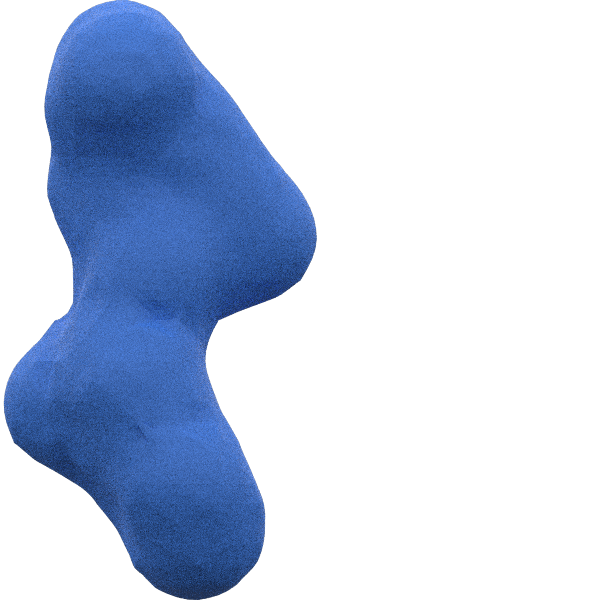

In [264]:
view='front'

n_samples = 50
scene1 = fresnel.Scene()
geom = fresnel.geometry.Mesh(scene1,vertices=v[f].reshape(-1,3),N=1)
geom.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]), roughness=0.6)
scene1.camera = fresnel.camera.fit(scene1,view=view, margin=0)
scene1.lights = fresnel.light.cloudy()
fresnel.pathtrace(scene1, samples=n_samples, h=600, w=600)


In [265]:
vmake_vol(v[f]/2).sum()


DeviceArray(259.80927, dtype=float32)